In [1]:
import os
import numpy as np
from PIL import Image
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
%matplotlib inline

In [2]:
root = './k_mean_data/'

# Image Denoise

In [3]:
def get_bin_table(threshold=128):
    table = []
    for i in range(256):
        if i < threshold:
            table.append(0)
        else:
            table.append(1)
    return table

def remove_noise_pixel(img, noise_point_list):
    for item in noise_point_list:
        img.putpixel((item[0], item[1]), 1)

def collect_noise_point(img):
    noise_point_list = []
    for x in range(img.width):
        for y in range(img.height):
            res_9 = sum_9_region_new(img, x, y)
            if (0 < res_9 < 3) and img.getpixel((x, y)) == 0:
                pos = (x, y)
                noise_point_list.append(pos)
    return noise_point_list

def sum_9_region_new(img, x, y):
    cur_pixel = img.getpixel((x, y))
    width = img.width
    height = img.height
    if cur_pixel == 1:
        return 0
    if y < 3:
        return 1
    elif y > height - 3:
        return 1
    else:
        if x < 3:
            return 1
        elif x == width - 1:
            return 1
        else:
            sum = img.getpixel((x - 1, y - 1)) \
                  + img.getpixel((x - 1, y)) \
                  + img.getpixel((x - 1, y + 1)) \
                  + img.getpixel((x, y - 1)) \
                  + cur_pixel \
                  + img.getpixel((x, y + 1)) \
                  + img.getpixel((x + 1, y - 1)) \
                  + img.getpixel((x + 1, y)) \
                  + img.getpixel((x + 1, y + 1))
            return 9 - sum


In [4]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Get label

In [5]:
label_list = {}

f = open('training data dic.txt', 'r', encoding="utf-8")
for idx, line in enumerate(f.readlines()):
    if idx == 50:
        break
    label_list[line[0]] = idx

# Load data

In [6]:
is_denoise = False
transform = transforms.Compose([
    transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), fill=255),
    transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(0.8, 1)),
])
is_augment = True
data = []
files = []
labels = []
binary = None

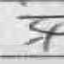

In [7]:
for idx, dir_ in enumerate(os.listdir(root)):
    for _, file in enumerate(os.listdir(root + '/' + dir_)):
        img_path = root + dir_ + '/' + file
        img = Image.open(img_path)
        img = img.resize((64, 64))
        if is_augment:
            #print(label_list[file[-5:-4]])
            random_rotate = transforms.RandomRotation(degrees=(-10, 10), fill=255)
            trans_img = random_rotate(img)
            im = np.array(trans_img).reshape(-1)
            data.append(im)
            files.append(img_path)
            labels.append(label_list[file[-5:-4]])

            random_translate = transforms.RandomAffine(degrees=(0, 0), translate=(0.1, 0.1), fill=255)
            trans_img = random_translate(img)
            im = np.array(trans_img).reshape(-1)
            data.append(im)
            files.append(img_path)
            labels.append(label_list[file[-5:-4]])

            random_colorjitter = transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(0.8, 1))
            trans_img = random_colorjitter(img)
            im = np.array(trans_img).reshape(-1)
            data.append(im)
            files.append(img_path)
            labels.append(label_list[file[-5:-4]])

            trans_img = transform(img)
            im = np.array(trans_img).reshape(-1)
            data.append(im)
            files.append(img_path)
            labels.append(label_list[file[-5:-4]])

        im = np.array(img).reshape(-1)
        if is_denoise:
            table = get_bin_table(np.mean(im))
            binary = img.point(table, '1')
            noise_point_list = collect_noise_point(binary)
            remove_noise_pixel(binary, noise_point_list)
            im = np.array(binary).reshape(-1)
        data.append(im)
        files.append(img_path)
        labels.append(label_list[file[-5:-4]])
data = np.array(data)
img

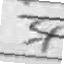

In [10]:
random_rotate = transforms.RandomRotation(degrees=(-10, 10), fill=255)
trans_img = random_rotate(img)
trans_img

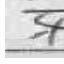

In [12]:
random_translate = transforms.RandomAffine(degrees=(0, 0), translate=(0.1, 0.1), fill=255)
trans_img = random_translate(img)
trans_img

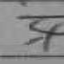

In [13]:
random_colorjitter = transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(0.8, 1))
trans_img = random_colorjitter(img)
trans_img

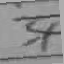

In [14]:
trans_img = transform(img)
trans_img

In [15]:
print(data.shape)
len(labels)

(14405, 4096)


14405

# Normalize data

In [8]:
nor_data = preprocessing.normalize(data)
print(nor_data[0])

[0.01753091 0.01753091 0.01753091 ... 0.01753091 0.01753091 0.01753091]


In [9]:
test_root = './test_data/'
X_test = []
y_test = []
for _, file in enumerate(os.listdir(test_root)):
    img_path = test_root + file
    img = Image.open(img_path).convert('L')
    img = img.resize((64, 64))
    img_data = np.array(img).reshape(-1)
    X_test.append(img_data)
    y_test.append(label_list[file[-5:-4]])
X_test = np.array(X_test)
y_test = np.array(y_test)
test_nor_data = preprocessing.normalize(X_test)

# Dimension reduce with PCA


In [10]:
from sklearn.decomposition import PCA
is_reduce_dim = True
if is_reduce_dim:
    pca = PCA(n_components=0.8, random_state=0)
    pca.fit(nor_data)
    nor_data = pca.transform(nor_data)
    print(nor_data.shape)

    test_nor_data = pca.transform(test_nor_data)
    print(test_nor_data.shape)
    print(test_nor_data[0][0])

(14405, 192)
(30, 192)
0.012882573929380643


# Save the PCA Data

In [16]:
if is_reduce_dim:
    np.save('k_means_data_pca', nor_data)
    print(nor_data.shape)
    nor_data = np.load('k_means_data_pca.npy')
    print(nor_data.shape)

    labels = np.array(labels)
    np.save('k_means_labels_pca', labels)
    print(labels.shape)
    labels = np.load('k_means_labels_pca.npy')
    print(labels.shape)

(14405, 192)
(14405, 192)
(14405,)
(14405,)


In [11]:
if is_reduce_dim:
    np.save('test_data_pca', test_nor_data)
    test_nor_data = np.load('test_data_pca.npy')
    print(test_nor_data.shape)
    print(test_nor_data[0][0])

    print(y_test.shape)
    np.save('test_label_pca', y_test)
    y_test = np.load('test_label_pca.npy')
    print(y_test.shape)
    print(y_test[0])

(30, 192)
0.012882573929380643
(30,)
(30,)
38


# Split training set and validation set

In [17]:
X_train, X_val, y_train, y_val = train_test_split(nor_data, labels, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_val.shape)
print(len(y_train))
print(len(y_val))

(11524, 4096)
(2881, 4096)
11524
2881


# K-nearest neighbors Classifier

In [14]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = [1, 5, 9, 15, 50, 100]
for n_neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n_neighbor, algorithm='auto', leaf_size=1, weights='distance')
    knn.fit(X_train, y_train)
    print("Evaluation:", n_neighbor, "n_neighbor")
    y_pred = knn.predict(X_val)
    knn_f1 = metrics.f1_score(y_val, y_pred, average= "weighted")
    print("F1 score: {}".format(knn_f1))
    knn_accuracy = metrics.accuracy_score(y_val, y_pred)
    print("Accuracy score: {}".format(knn_accuracy))
    
    print(metrics.classification_report(y_val[:10],y_pred[:10]))

Evaluation: 1 n_neighbor
F1 score: 0.6363766146776364
Accuracy score: 0.623741756334606


c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         1
          26       1.00      1.00      1.00         1
          28       0.00      0.00      0.00         1
          29       1.00      1.00      1.00         1
          30       0.00      0.00      0.00         0
          31       0.00      0.00      0.00         1
          34       0.00      0.00      0.00         1
          35       0.00      0.00      0.00         0
          40       0.00      0.00      0.00         0
          41       0.00      0.00      0.00         1
          42       0.00      0.00      0.00         0
          44       0.00      0.00      0.00         0
          45       0.00      0.00      0.00         1

    accuracy              

c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation:

KeyboardInterrupt: 

In [15]:
param_grid = {'n_neighbors':n_neighbors, 'algorithm':['auto'], 'leaf_size': [1], 'weights':['distance']}
knn = KNeighborsClassifier()
gridKNN = GridSearchCV(knn, param_grid, refit=True, verbose=2, n_jobs=4)
gridKNN.fit(X_train, y_train)
print(gridKNN.best_score_)
print(gridKNN.best_params_)
print(gridKNN.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 29.7min finished


0.6433528787057123
{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 1, 'weights': 'distance'}
KNeighborsClassifier(leaf_size=1, n_neighbors=1, weights='distance')


# KNN report and analysis

-----------------KNN Report---------------
F1 score: 0.6942265298100196
Accuracy score: 0.6910794862894828
Confusion matrix for random 10 classes: 
 [[0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]
Plotting confusion matrix for random 10 classes


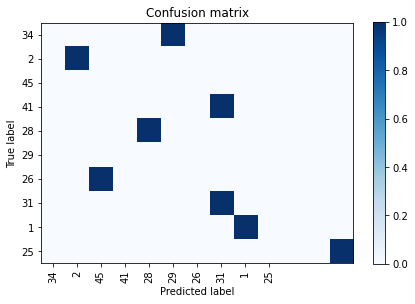

              precision    recall  f1-score   support

           0       0.61      0.70      0.65        79
           1       0.87      0.62      0.73        72
           2       0.64      0.75      0.69        48
           3       0.74      0.62      0.67        47
           4       0.76      0.77      0.76        61
           5       0.59      0.75      0.66        59
           6       0.83      0.75      0.79        65
           7       0.77      0.66      0.71        65
           8       0.48      0.75      0.59        55
           9       0.76      0.76      0.76        49
          10       0.57      0.62      0.60        40
          11       0.85      0.81      0.83        72
          12       0.85      0.65      0.74        71
          13       0.74      0.63      0.68        51
          14       0.78      0.61      0.69        57
          15       0.68      0.84      0.75        50
          16       0.54      0.70      0.61        40
          17       0.78    

In [16]:
y_pred_knn = gridKNN.predict(X_val)
knn_f1 = metrics.f1_score(y_val, y_pred_knn, average= "weighted")
knn_accuracy = metrics.accuracy_score(y_val, y_pred_knn)
knn_cm = metrics.confusion_matrix(y_val[:10], y_pred_knn[:10])
print("-----------------KNN Report---------------")
print("F1 score: {}".format(knn_f1))
print("Accuracy score: {}".format(knn_accuracy))
print("Confusion matrix for random 10 classes: \n", knn_cm)
print('Plotting confusion matrix for random 10 classes')

plt.figure()
plot_confusion_matrix(knn_cm[:10], y_val[:10])
plt.show()

print(metrics.classification_report(y_val, y_pred_knn))


# Naive Bayes Classifier

In [11]:
from sklearn.naive_bayes import *
if not is_reduce_dim:
    Categorical_NB = CategoricalNB()
    Categorical_NB.fit(X_train, y_train)

    Complement_NB = ComplementNB()
    Complement_NB.fit(X_train, y_train)

    Gaussian_NB = GaussianNB()
    Gaussian_NB.fit(X_train, y_train)

    Multinomial_NB = MultinomialNB()
    Multinomial_NB.fit(X_train, y_train)


# Naive Bayes Classifier report and analysis

-----------------Naive Bayes Classifier Report---------------
CategoricalNB F1 score: 0.0012523391764078004 and Accuracy score: 0.025338424158278375
ComplementNB F1 score: 0.17163770452106317 and Accuracy score: 0.206872613675807
GaussianNB F1 score: 0.25374524541434307 and Accuracy score: 0.2651856994099271
MultinomialNB F1 score: 0.07215686196118869 and Accuracy score: 0.12044429017702186
Confusion matrix for random 10 classes: 
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0

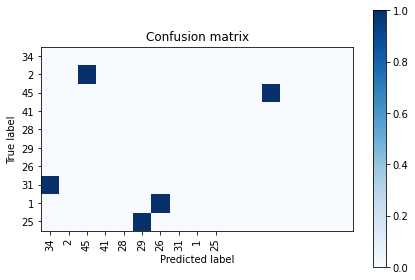

              precision    recall  f1-score   support

           0       0.18      0.24      0.20        79
           1       0.25      0.04      0.07        72
           2       0.16      0.23      0.19        48
           3       0.12      0.19      0.14        47
           4       0.37      0.11      0.17        61
           5       0.55      0.46      0.50        59
           6       0.29      0.26      0.27        65
           7       0.20      0.15      0.17        65
           8       0.23      0.49      0.31        55
           9       0.29      0.37      0.32        49
          10       0.38      0.23      0.28        40
          11       0.38      0.24      0.29        72
          12       0.39      0.37      0.38        71
          13       0.25      0.29      0.27        51
          14       0.23      0.32      0.26        57
          15       0.40      0.38      0.39        50
          16       0.27      0.42      0.33        40
          17       0.14    

In [12]:
y_pred_Categorical_NB = Categorical_NB.predict(X_val)
y_pred_Complement_NB = Complement_NB.predict(X_val)
y_pred_Gaussian_NB = Gaussian_NB.predict(X_val)
y_pred_Multinomial_NB = Multinomial_NB.predict(X_val)

Categorical_NB_f1 = metrics.f1_score(y_val, y_pred_Categorical_NB, average= "weighted")
Complement_NB_f1 = metrics.f1_score(y_val, y_pred_Complement_NB, average= "weighted")
Gaussian_NB_f1 = metrics.f1_score(y_val, y_pred_Gaussian_NB, average= "weighted")
Multinomial_NB_f1 = metrics.f1_score(y_val, y_pred_Multinomial_NB, average= "weighted")

Categorical_NB_accuracy = metrics.accuracy_score(y_val, y_pred_Categorical_NB)
Complement_NB_accuracy = metrics.accuracy_score(y_val, y_pred_Complement_NB)
Gaussian_NB_accuracy = metrics.accuracy_score(y_val, y_pred_Gaussian_NB)
Multinomial_NB_accuracy = metrics.accuracy_score(y_val, y_pred_Multinomial_NB)

Gaussian_NB_cm = metrics.confusion_matrix(y_val[:10], y_pred_Gaussian_NB[:10])

print("-----------------Naive Bayes Classifier Report---------------")
print("CategoricalNB F1 score: {} and Accuracy score: {}".format(Categorical_NB_f1, Categorical_NB_accuracy))
print("ComplementNB F1 score: {} and Accuracy score: {}".format(Complement_NB_f1, Complement_NB_accuracy))
print("GaussianNB F1 score: {} and Accuracy score: {}".format(Gaussian_NB_f1, Gaussian_NB_accuracy))
print("MultinomialNB F1 score: {} and Accuracy score: {}".format(Multinomial_NB_f1, Multinomial_NB_accuracy))
print("Confusion matrix for random 10 classes: \n", Gaussian_NB_cm)
print('Plotting confusion matrix for random 10 classes')

plt.figure()
plot_confusion_matrix(Gaussian_NB_cm[:10], y_val[:10])
plt.show()

print(metrics.classification_report(y_val, y_pred_Gaussian_NB))

# SVM Classifier

In [20]:
from sklearn.svm import SVC

kernels = ['poly', 'rbf', 'sigmoid','linear']
for kernel in kernels:
    svc = SVC(kernel=kernel)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_val)
    svc_f1 = metrics.f1_score(y_val, y_pred, average= "weighted")
    print("Evaluation:", kernel, "kernel")
    print("F1 score: {}".format(svc_f1))
    svc_accuracy = metrics.accuracy_score(y_val, y_pred)
    print("Accuracy score: {}".format(svc_accuracy))
    print(metrics.classification_report(y_val[:10],y_pred[:10]))


In [21]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': ['scale', 'auto'],'kernel': kernels[:2]}
svc = SVC()
grid_svc = GridSearchCV(svc, param_grid, refit=True, verbose=2, n_jobs=4)
grid_svc.fit(X_train, y_train)
print(grid_svc.best_score_)
print(grid_svc.best_params_)
print(grid_svc.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 276.9min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 621.7min finished


0.6538528862376476
{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
SVC(C=100)


# SVM Classifier report and analysis

-----------------SVM Classifier Report---------------
F1 score: 0.6874083188382907
Accuracy score: 0.6886497743838945
Confusion matrix for random 10 classes: 
 [[1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]]
Plotting confusion matrix for random 10 classes


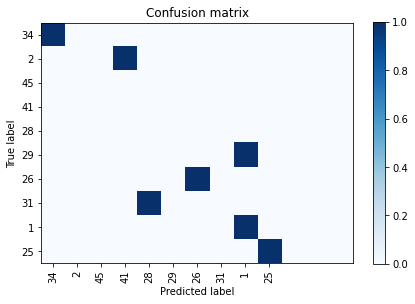

              precision    recall  f1-score   support

           0       0.59      0.68      0.64        79
           1       0.68      0.56      0.61        72
           2       0.80      0.90      0.84        48
           3       0.68      0.55      0.61        47
           4       0.60      0.64      0.62        61
           5       0.60      0.83      0.70        59
           6       0.60      0.75      0.67        65
           7       0.62      0.80      0.70        65
           8       0.63      0.65      0.64        55
           9       0.75      0.82      0.78        49
          10       0.60      0.70      0.64        40
          11       0.67      0.86      0.76        72
          12       0.84      0.76      0.80        71
          13       0.63      0.63      0.63        51
          14       0.62      0.68      0.65        57
          15       0.62      0.70      0.66        50
          16       0.58      0.62      0.60        40
          17       0.68    

In [22]:
y_pred_svc = grid_svc.predict(X_val)
svc_f1 = metrics.f1_score(y_val, y_pred_svc, average= "weighted")
svc_accuracy = metrics.accuracy_score(y_val, y_pred_svc)
svc_cm = metrics.confusion_matrix(y_val[:10], y_pred_svc[:10])
print("-----------------SVM Classifier Report---------------")
print("F1 score: {}".format(svc_f1))
print("Accuracy score: {}".format(svc_accuracy))
print("Confusion matrix for random 10 classes: \n", svc_cm)
print('Plotting confusion matrix for random 10 classes')

plt.figure()
plot_confusion_matrix(svc_cm[:10], y_val[:10])
plt.show()

print(metrics.classification_report(y_val, y_pred_svc))

# MLP Classifier

In [40]:
# from sklearn.neural_network import MLPClassifier
#
# clf = MLPClassifier(hidden_layer_sizes=(512, 512, 64), verbose=2, max_iter=500)
# clf.fit(X_train, y_train)

Iteration 1, loss = 3.91851740
Iteration 2, loss = 3.90668161
Iteration 3, loss = 3.89493631
Iteration 4, loss = 3.87659171
Iteration 5, loss = 3.84345641
Iteration 6, loss = 3.78277609
Iteration 7, loss = 3.68657792
Iteration 8, loss = 3.56533681
Iteration 9, loss = 3.44133515
Iteration 10, loss = 3.32320171
Iteration 11, loss = 3.21317001
Iteration 12, loss = 3.11151858
Iteration 13, loss = 3.02804539
Iteration 14, loss = 2.95906798
Iteration 15, loss = 2.88374073
Iteration 16, loss = 2.81685173
Iteration 17, loss = 2.75176799
Iteration 18, loss = 2.69673035
Iteration 19, loss = 2.66375226
Iteration 20, loss = 2.62564347
Iteration 21, loss = 2.58992327
Iteration 22, loss = 2.54574885
Iteration 23, loss = 2.52014356
Iteration 24, loss = 2.49599454
Iteration 25, loss = 2.46306056
Iteration 26, loss = 2.43552794
Iteration 27, loss = 2.40927351
Iteration 28, loss = 2.38796950
Iteration 29, loss = 2.36850509
Iteration 30, loss = 2.33187247
Iteration 31, loss = 2.30099040
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(512, 512, 64), max_iter=500, verbose=2)

# MLP Classifier report and analysis

-----------------MLP Classifier Report---------------
F1 score: 0.2535845676284849
Accuracy score: 0.24783362218370883
Confusion matrix for random 10 classes: 
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]
Plotting confusion matrix for random 10 classes


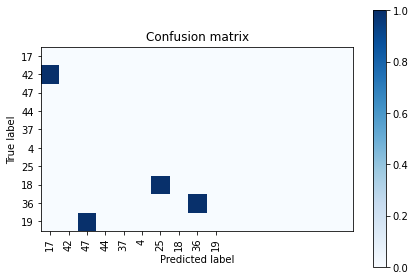

              precision    recall  f1-score   support

           0       0.29      0.29      0.29        14
           1       0.00      0.00      0.00        10
           2       0.38      0.38      0.38         8
           3       0.00      0.00      0.00         3
           4       0.29      0.12      0.17        17
           5       0.33      0.25      0.29        12
           6       0.36      0.50      0.42        10
           7       0.27      0.29      0.28        14
           8       0.25      0.25      0.25         8
           9       0.29      0.15      0.20        13
          10       0.08      0.10      0.09        10
          11       0.42      0.29      0.34        17
          12       0.36      0.31      0.33        13
          13       0.25      0.30      0.27        10
          14       0.25      0.38      0.30         8
          15       0.71      0.31      0.43        16
          16       0.42      0.50      0.45        10
          17       0.33    

In [41]:
# y_pred_mlp = clf.predict(X_val)
# mlp_f1 = metrics.f1_score(y_val, y_pred_mlp, average= "weighted")
# mlp_accuracy = metrics.accuracy_score(y_val, y_pred_mlp)
# mlp_cm = metrics.confusion_matrix(y_val[:10], y_pred_mlp[:10])
# print("-----------------MLP Classifier Report---------------")
# print("F1 score: {}".format(mlp_f1))
# print("Accuracy score: {}".format(mlp_accuracy))
# print("Confusion matrix for random 10 classes: \n", mlp_cm)
# print('Plotting confusion matrix for random 10 classes')
#
# plt.figure()
# plot_confusion_matrix(mlp_cm[:10], y_val[:10])
# plt.show()
#
# print(metrics.classification_report(y_val, y_pred_mlp))
